In [1]:
# Function for generating histogram
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import datetime 
import import_ipynb
import histplot

importing Jupyter notebook from histplot.ipynb


In [2]:
ASC = '__ASC_ASCIIIn.mrk'
direct = 'C:/Users/tyron/Documents/Geoscience/weather/'

In [42]:
# Summer 2018 as an example
Summer18 = histplot.getData(18, direct, ASC, 152, 92, 6 , float)
Whole18 = histplot.getData(18, direct, ASC, 1, 365, 6, float)


In [4]:
def calc(precip_data, what_bin):
    hist, bin_edge = np.histogram(precip_data, bins = what_bin)
    log_y = np.log(hist)
    bin_val = np.zeros(len(what_bin)-1)
    for i in range(len(what_bin)-1):
        bin_val[i] = (what_bin[i] + what_bin[i+1])/2
    logx = np.log(bin_val)
    curve_fit = np.polyfit(logx, log_y,1)
    curve_fit[1] = np.exp(curve_fit[1])
    return curve_fit, bin_val

In [5]:
# Exponentials get from durations
def exponential(in_put, exclude, length):
    first_bin = np.zeros(length)
    for i in range(length):    
        first_bin[i] = np.percentile(in_put, i*(100/(length-1)))
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals
    

In [6]:
# Exponentials get from intensity
def exponential_int(in_put, exclude):
    first_bin = np.zeros(51)
    for i in range(0, 51):    
        first_bin[i] = np.round(np.percentile(in_put, i*2),2)
    second_bin = np.unique(first_bin)
    stop1 = np.array([exclude])
    final_bin = np.setdiff1d(second_bin, stop1)
    curvefit, bin_vals = calc(in_put, final_bin)
    return curvefit, final_bin, bin_vals

In [7]:
def counting(data, want):
    counts = 0
    newdata = data[data < want]
    counts = len(newdata)
    return counts

In [40]:
def model_1(data, amount, howmuch):
    precip, nonprecip, preciptotal, totalprep = histplot.preciphist(data, len(data), amount, 1, 1)
    count = 0
    count1 = 0
    for i in range(0, len(precip)):
        hold = precip[i]
        hold1 = nonprecip[i]
        if hold > 0:
            count += 1
        if hold1 > 0:
            count1 += 1
    precip = precip[:count]
    nonprecip = nonprecip[:count1]
    preciptotal = preciptotal[:count]
    # Calculate intensities 
    inten = np.divide(preciptotal, precip)
    # Exponentials for precipitation duration 
    pre_exp,pre_f_bins, bin_vals = exponential(precip, 1, 51)
    # Exponentials for nonprecipitation duration 
    non_pre, nonpre_f_bins, nonp_b_vals = exponential(nonprecip, 1, 51)
    # Exponentials for Intensity of Precipitation duration
    intensity, inten_f_bins, inten_b_vals = exponential_int(inten, 0.01)
    # print(nonpre_f_bins)
    # Construct intervals and probabilities for precipitation durations
    Pre_prob = np.zeros(1)
    pre_bin_1 = counting(precip, pre_f_bins[0])
    Pre_prob[0] = pre_bin_1
    construct_1 = pre_exp[1]*np.exp(np.log(bin_vals)*pre_exp[0])
    Pre_prob = np.append(Pre_prob, construct_1)
    Pre_prob = Pre_prob/sum(Pre_prob)
    #print(Pre_prob)
    # Non_precipitation duration probs
    NonPre_prob = np.zeros(1)
    nonpre_bin_1 = counting(nonprecip, nonpre_f_bins[0])
    NonPre_prob[0] = nonpre_bin_1
    construct_2 = non_pre[1]*np.exp(np.log(nonp_b_vals)*non_pre[0])
    NonPre_prob = np.append(NonPre_prob, construct_2)
    NonPre_prob = NonPre_prob/sum(NonPre_prob)
    #print(NonPre_prob)
    # Intensity probs
    Intensity_prob = np.zeros(1)
    inten_bin_1 = counting(inten, inten_f_bins[0])
    Intensity_prob[0] = inten_bin_1
    construct_3 = intensity[1]*np.exp(np.log(inten_b_vals)*intensity[0])
    Intensity_prob = np.append(Intensity_prob, construct_3)
    Intensity_prob = Intensity_prob/sum(Intensity_prob)
    #print(Intensity_prob)
    # Precipitation intervals
    Pre_interval = [1]
    Pre_interval = np.append(Pre_interval, pre_f_bins)
    #print(Pre_interval)
    # NonPrecipitation intervals
    NonPre_interval = [1]
    NonPre_interval = np.append(NonPre_interval, nonpre_f_bins)
    #print(NonPre_interval)
    # Intensity intervals
    Intensity_interval = [0.01]
    Intensity_interval = np.append(Intensity_interval, inten_f_bins)
    #print(Intensity_interval)
    Model_outputs = 0;
    # Running the crude model
    for i in range(howmuch):
        minutes = 0;
        Model = np.zeros(len(data))
        start = np.random.randint(0, 1)
        while (len(data)-1 > minutes):
            # run probability of precipitation event duration      
            pre_index = np.random.choice(np.arange(len(Pre_prob)), p = Pre_prob)
            pre_duration = np.random.randint(Pre_interval[pre_index], Pre_interval[pre_index + 1]+1) #Histogram for these synthetic data, show that they are similar 
            # to what you put in. 
            # run probability of precipitation event intensity
            inten_index = np.random.choice(np.arange(len(Intensity_prob)), p = Intensity_prob)
            model_intensity = 0.01*np.random.randint(100*Intensity_interval[inten_index], 100*Intensity_interval[inten_index+1]+1)
            # run probability of non-precipitation event duration
            nonpre_index = np.random.choice(np.arange(len(NonPre_prob)), p = NonPre_prob) 
            nonpre_duration = np.random.randint(NonPre_interval[nonpre_index], NonPre_interval[nonpre_index + 1]+1)
            # For each of the synthetic data have a histogram and look at to see if it is similar to what we calcluated for observed data. 
            # Nonprecipitation starts first
            if start == 0: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                else: 
                    if (len(data) < minutes + nonpre_duration):
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
                    elif (len(data) < minutes + nonpre_duration + pre_duration):
                        for j in range(nonpre_duration):
                            Model[minutes] = 0
                            minutes += 1
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
            # Precipitation starts first
            if start == 1: 
                if (len(data) > minutes + pre_duration + nonpre_duration):
                    for k in range(pre_duration):
                        Model[minutes] = model_intensity
                        minutes += 1
                    for j in range(nonpre_duration):
                        Model[minutes] = 0
                        minutes += 1
                else: 
                    if (len(data) < minutes + pre_duration):
                        for k in range(len(data) - minutes):
                            Model[minutes] = model_intensity
                            minutes +=1
                    elif (len(data) < minutes + pre_duration + nonpre_duration):
                        for k in range(pre_duration):
                            Model[minutes] = model_intensity
                            minutes += 1
                        for j in range(len(data) - minutes):
                            Model[minutes] = 0
                            minutes += 1
        Model_outputs = Model
    return Model_outputs, data 

In [43]:
sample_output, compare_data = model_1(Whole18, 5000, 1)

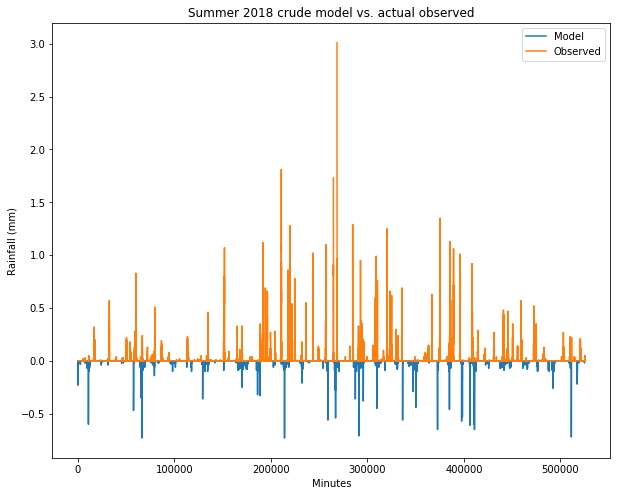

In [44]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(compare_data)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'], loc = 'upper right')

In [45]:
Su_precip18, Su_nonprecip18, Su_preciptotal18, Su_totalprep18 = histplot.preciphist(Whole18, len(Whole18), 5000, 1, 1)

In [46]:
Su_nonprecip18 = Su_nonprecip18[Su_nonprecip18>0]
Su_precip18 = Su_precip18[Su_precip18>0]
#print(Su_precip18)
#print(Su_nonprecip18)


In [47]:
Su_preciptotal18 = Su_preciptotal18[Su_preciptotal18 > 0]


In [48]:
Su_inten18 = np.divide(Su_preciptotal18, Su_precip18)
print(len(Su_inten18))

4118


In [49]:
print(Su_nonprecip18.sum() + Su_precip18.sum())
print(len(Su_nonprecip18))
print(len(Su_precip18))
print(len(compare_data))
print(len(sample_output))

525562.0
4119
4118
525589
525589


In [50]:
hold = np.sum(Su_nonprecip18) + np.sum(Su_precip18)
new_summer18 = np.zeros(int(hold))
minute = 0;
pre_index = 0;
np_index = 0;
while(int(hold)-1 > minute):
    if (len(Su_nonprecip18) > np_index):
        non = Su_nonprecip18[np_index]
        for i in range(int(non)):
            new_summer18[minute] = 0
            minute += 1
    if (len(Su_precip18)> pre_index):    
        rain = Su_precip18[pre_index]
        for j in range(int(rain)):
            new_summer18[minute] = Su_inten18[pre_index]
            minute += 1
    pre_index += 1 
    np_index +=1


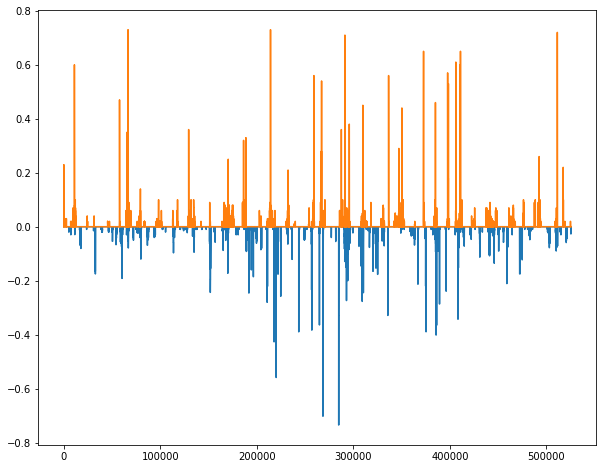

In [53]:
plt.figure(figsize = (10,8))
plt.plot(-new_summer18)
plt.plot(sample_output)

In [21]:
# Starts with a simple model accuracy, precip with precip. 
def mod_acc1(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
            #mod_accuracy += 1
        if (mod > 0 and obs > 0):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [22]:
# maintains exact match for precip
def mod_acc2(model, observed, pre_min):
    mod_accuracy = 0
    for i in range(len(observed)):
        mod = model[i]
        obs = observed[i]
        #if (mod == 0 and obs == 0):
           # mod_accuracy += 1
        if (mod > 0 and obs > 0 and mod == obs):
            mod_accuracy += 1
        else: 
            mod_accuracy += 0
    mod_accuracy = 100*mod_accuracy/pre_min
    return mod_accuracy

In [23]:
pre_min = sum(Su_precip18)
print(pre_min)

3427.0


In [24]:
model_accuracy = 0
for i in range(len(new_summer18)):
    mod = sample_output[i]
    obs = new_summer18[i]
    if (mod == 0 and obs == 0):
        model_accuracy += 1
    elif (mod > 0 and obs > 0):
        model_accuracy += 1
    else: 
        model_accuracy += 0
model_accuracy = model_accuracy/len(new_summer18)
print(mod_acc1(sample_output, new_summer18, pre_min))
print(mod_acc2(sample_output, new_summer18, pre_min))
pre_accuracy = mod_acc1(sample_output, new_summer18, pre_min)

1.0504814706740588
0.2626203676685147


In [25]:
print(model_accuracy)

0.9447237698358775


In [57]:
sample_output, compare_data = model_1(Whole18, 20000, 1)

Text(0.9, 0.7, 'Model percent without precipitation: 96.6 %')

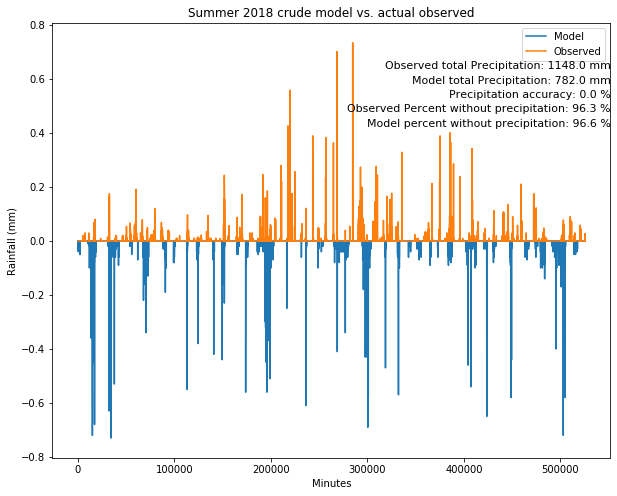

In [58]:
plt.figure(figsize = (10, 8))
plt.plot(-sample_output)
plt.plot(new_summer18)
plt.title('Summer 2018 crude model vs. actual observed')
plt.xlabel('Minutes')
plt.ylabel('Rainfall (mm)')
plt.legend(['Model', 'Observed'], loc = 'upper right')
plt.figtext(0.9, 0.8, 'Observed total Precipitation: ' + str(round(Su_totalprep18)) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.775, 'Model total Precipitation: ' + str(round(sum(sample_output))) + ' mm', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.75, 'Precipitation accuracy: ' + str(round(pre_accuracy)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.725, 'Observed Percent without precipitation: ' + str(round(len(new_summer18[new_summer18 == 0])/len(new_summer18)*100,1)) + ' %', fontsize = 11, ha = 'right')
plt.figtext(0.9, 0.7, 'Model percent without precipitation: ' + str(round(len(sample_output[sample_output == 0])/len(sample_output)*100,1)) + ' %', fontsize = 11, ha = 'right')

In [29]:
average_precip = 0
avg_precip_accur = 0
for i in range(100):
    sample_output, compare_data = model_1(Summer18, 5000, 1)
    average_precip = average_precip + sum(sample_output)
    pre_accuracy = mod_acc1(sample_output, new_summer18, pre_min)
    avg_precip_accur = avg_precip_accur + pre_accuracy
average_precip = average_precip/100
avg_precip_accur = avg_precip_accur/100

print(average_precip)
print(avg_precip_accur)

115.22910000000124
2.7184126057776483


In [32]:
# Key try to run the simulated data and spit out the coefficients. To make sure you know what is going on. 
# it looks like intensity and duration of non-precipitation events are off, perhaps not getting the upper ranges.
mod_precip18, mod_nonprecip18, mod_preciptotal18, mod_totalprep18 = histplot.preciphist(sample_output, len(sample_output), 5000, 1, 1)
print(len(mod_precip18))
print(len(mod_nonprecip18))
print(len(mod_preciptotal18))

5000
5000
5000


In [33]:
def count_zero(data, want):
    counts = 0
    newdata = data[data > want]
    counts = len(newdata)
    return newdata

In [34]:
mod_precip18 = count_zero(mod_precip18, 0)
print(len(mod_precip18))

350


In [35]:
print(mod_precip18)

[  4.   5.   1.   2.   1.   1.   2.   2.   4.  12.   2.   1.   6.   1.
   4.  37.   9.   7.   1. 158.   1.   4.   1.   4.   1.   1.   3.   1.
   1.   1.   3.   4.   1.   2.   3.   1.   1.  17.   2.   2.   1.   2.
   9.   2.  10.   3.   3.   2.   3.   2.   4.  12. 161.   1.   2.   2.
   1.   2.   2.   2.   1.   2. 121.   1.  26.   1.   4.   5.   2.   2.
   1.   2.  79.   1.   3.   1.   2.   6.   1. 130.  87.   5.   3.   1.
   4.   1.  64.   8.   2. 185.   3.   6.   2.   1.  64.   2.  13.   1.
   2.   1.   2.   2.   4.   1.   2.   2.   3.   1.   2.   4.   7.   1.
   8.   1.   9.   1.   2.  19.   3.   4.   2.   5.   1.   2.   3.  19.
   1.   2.   2.   2. 136.   1.   5.   1.   3.   4.   2.   2.   1.   3.
  10.   1.   2.   6. 190.   2.   2.   2.   1.   2.   2.   1.   1.   1.
   2.   1.  15.   8.   3.   1.   1.   2.   1.   4.   4.   1.   2.   1.
  10.   2.   1.   6.   4.   6.   9.   1.   1.   2.  14.  14.   1.   2.
   1.   2.   2.   3.   3.   4.   1.   1.   2.   1.   2.   7.   2.   1.
   1. 

In [36]:
mod_nonprecip18 = count_zero(mod_nonprecip18, 0)
print(len(mod_nonprecip18))
print(mod_nonprecip18)

351
[1.0000e+00 2.0000e+00 1.1200e+02 4.0000e+00 4.0000e+00 3.0000e+01
 4.0000e+00 1.4700e+02 3.0000e+00 2.0000e+00 5.2200e+02 1.1000e+01
 1.3000e+01 1.0000e+00 1.0000e+00 8.0000e+00 3.0000e+00 3.0000e+00
 8.0000e+00 4.2000e+01 1.5900e+02 4.0000e+00 4.0000e+00 4.0000e+00
 9.1360e+03 6.0000e+00 9.2050e+03 1.6000e+01 2.0000e+00 1.5000e+01
 1.0000e+00 2.0000e+00 6.0000e+01 2.0000e+00 3.0000e+00 3.0000e+00
 3.0000e+00 5.0000e+00 3.0000e+00 9.0000e+00 2.0000e+00 1.1000e+01
 3.0000e+00 5.0000e+00 5.0000e+00 4.0000e+00 9.0000e+00 4.0000e+00
 4.1000e+01 2.0000e+00 1.1000e+01 4.0000e+00 4.0000e+00 2.2000e+01
 4.0000e+00 4.0000e+00 2.0000e+00 1.0000e+01 2.0000e+00 1.2000e+01
 2.4740e+03 2.1250e+03 6.0020e+03 1.3000e+01 3.0000e+00 1.9640e+03
 4.0000e+00 3.0000e+00 2.0000e+00 2.0000e+00 3.0000e+01 5.0000e+00
 4.1000e+01 2.0000e+00 3.1000e+01 1.5000e+01 8.0000e+00 1.3000e+01
 1.5300e+02 2.8000e+01 2.0000e+00 2.3000e+01 5.0000e+00 2.7800e+02
 9.0000e+00 3.7000e+02 1.1000e+01 1.2000e+01 3.1000e+01 3.

In [37]:
print(mod_preciptotal18)

[0.28 0.05 0.02 ... 0.   0.   0.  ]


In [38]:
mod_preciptotal18 = count_zero(mod_preciptotal18, 0)


In [39]:
precip_coef, final_bins, bin_vals = exponential(mod_precip18, 1)
print(precip_coef)

TypeError: exponential() missing 1 required positional argument: 'length'

In [35]:
nonprecip_coef, np_final_bins, np_bin_vals = exponential(mod_nonprecip18, 1)
print(nonprecip_coef)

[-0.0812516  24.17398685]


In [36]:
mod_inten = np.divide(mod_preciptotal18, mod_precip18)
print(mod_inten)

[0.01 0.02 0.01 0.01 0.02 0.01 0.01 0.07 0.02 0.02 0.02 0.01 0.03 0.01
 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.08 0.01 0.02
 0.01 0.01 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01 0.01 0.01 0.02 0.01
 0.02 0.02 0.07 0.03 0.01 0.02 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01
 0.01 0.02 0.01 0.01 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.01 0.01
 0.01 0.07 0.02 0.02 0.01 0.01 0.55 0.02 0.02 0.02 0.01 0.02 0.02 0.01
 0.02 0.02 0.01 0.07 0.02 0.01 0.02 0.02 0.01 0.02 0.02 0.01 0.01 0.01
 0.02 0.02 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.01 0.06 0.01 0.01 0.01
 0.02 0.01 0.01 0.01 0.02 0.01 0.02 0.43 0.02 0.01 0.01 0.01 0.01 0.02
 0.02 0.02 0.09 0.01 0.02 0.01 0.02 0.01 0.02 0.01 0.02 0.01 0.02 0.01
 0.02 0.02 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.06 0.01 0.02 0.02
 0.02 0.01 0.69 0.02 0.15 0.01 0.02 0.06 0.02 0.01 0.02 0.02 0.04 0.01
 0.02 0.06 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.01 0.02 0.01 0.02 0.02
 0.02 0.01 0.01 0.02 0.01 0.02 0.01 0.03 0.02 0.04 0.05 0.01 0.02 0.02
 0.01 

In [45]:
inten_coef, inten_fb, inten_bv = exponential_int(mod_inten, 0.01)

In [46]:
print(inten_coef)

[-0.79131158  1.84005618]
